Spectroscopic data reduction in six simple steps. The steps performed in this notebook are shown in **bold.**

Step 1: Trim and subtract bias from all the data.

Step 2: Flatfield the data.

Step 3: Construct a comparison lamp image from separate He and Ne lamps.

Step 4: Fit a wavelength solution to the lamp composite. 

**Step 5: Extract the 1-D spectrum and its wavelength solution.**

Step 6: Apply a relative flux calibration. 

$\rightarrow$ now you are ready to do a bit of analysis.

Piece of cake. 

In [1]:
# start by importing the essentials 
import numpy as np 
from matplotlib import pyplot as plt 

from astropy import units as u
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from astropy.modeling.polynomial import Polynomial1D
from astropy.io import ascii
from astropy.table import Table

# (0) read in the data

### Wavelength solution: 

In [2]:
# a long exposure He lamp
wav_sol = fits.open('/reduced/full_wave_sol.fits')[0].data

### Science Targets: 

In [3]:
# Castor - a bright binary star with both components acquired
castor2d = fits.open('/reduced/castor_f.fits')[0].data

# Beta CMi - a star with an interesting spectrum
betacmi2d = fits.open('/reduced/betacmi_f.fits')[0].data

### Flux calibrator: 

In [4]:
# Regulus is a spectral standard star with a known spectral energy distribution
regulus2d = fits.open('regulus_f.fits')[0].data

# (5) Extract the 1D spectrum from the 2D frame.  

Castor is a double star with both components of the binary in the slit, so let's start with Beta CMi. 

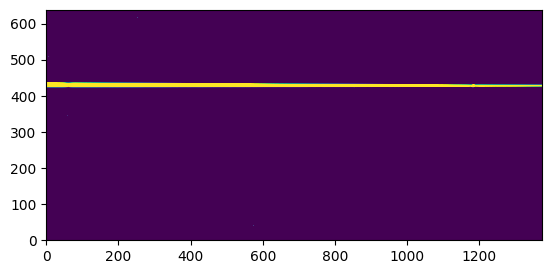

In [5]:
plt.imshow(betacmi2d, origin='lower', vmin=5000, vmax=20000)

We can estimate where the trace of the object is to first order using the simple method of finding the peak value in the y-direction.

In [6]:
yvals = np.argmax(betacmi2d, axis=0)
xvals = np.arange(betacmi2d.shape[1])

Text(0.5, 0, 'X position')

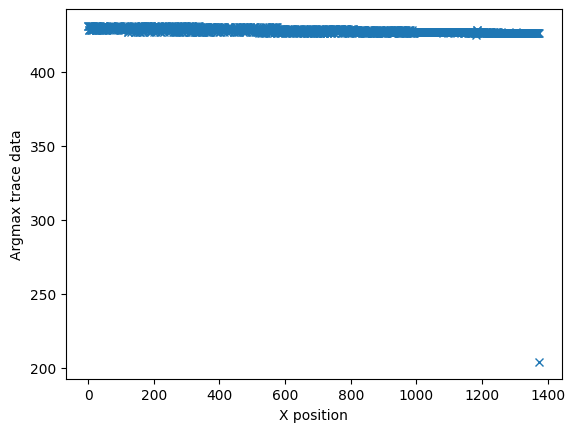

In [7]:
plt.plot(xvals, yvals, 'x')
plt.ylabel("Argmax trace data")
plt.xlabel("X position")

This looks pretty good because this is the spectrum of a nice, bright star with lots of signal. Another, possibly better, approach is to find the intensity-weighted pixel location. First, let's focus in on a region around where the spectrum is located in the 2D image. 

(400.0, 460.0)

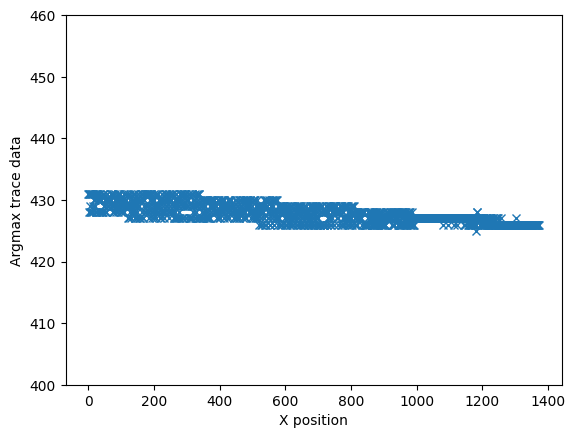

In [8]:
plt.plot(xvals, yvals, 'x')
plt.ylabel("Argmax trace data")
plt.xlabel("X position")

plt.ylim([400,460])

In [9]:
# define the upper and lower image bounds we want to use 
ylow = 400 
yhigh = 460

In [10]:
# we use a cutout around the traced line, so the y-values are from that cutout
# the `repeat` command here is used to extend the y-axis position values along the X-direction.  
# The indexing with [:, None] adds a "dummy" axis along the second (x) dimension,
# then `repeat` copies the y-axis values.  The resulting array has the same shape as the weight array.
yaxis = np.repeat(np.arange(ylow, yhigh)[:,None],
                  betacmi2d.shape[1], axis=1)
# subtract off the image median to avoid a bias toward the image center. 
background = np.median(betacmi2d)
# moment 1 is the data-weighted average of the Y-axis coordinates
weighted_yaxis_values = np.average(yaxis, axis=0,
                                   weights=betacmi2d[ylow:yhigh,:] - background)

Plot the positions and the weighted centroids on the image to make sure things are behaving as we expect. 

Text(0, 0.5, 'Moment-1 estimated Y-value trace')

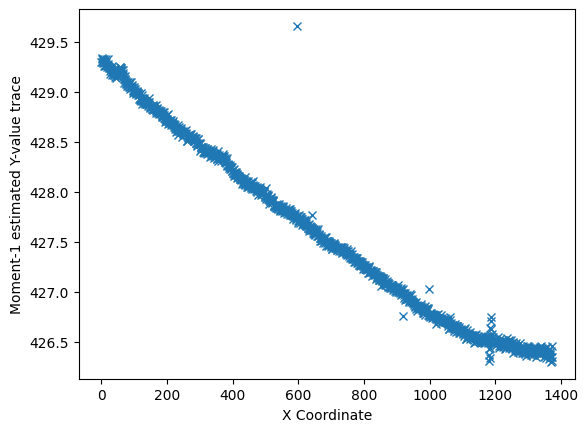

In [11]:
plt.plot(xvals, weighted_yaxis_values, 'x')
plt.xlabel("X Coordinate")
plt.ylabel("Moment-1 estimated Y-value trace")

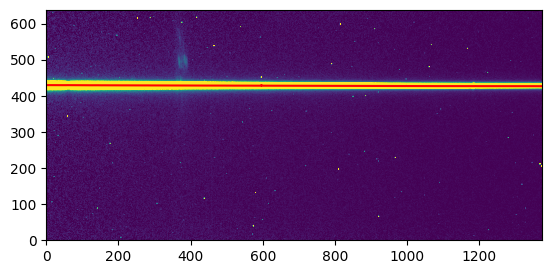

In [12]:
plt.imshow(betacmi2d, origin='lower', vmin=0, vmax=1000)
plt.plot(xvals, weighted_yaxis_values, color='red')

## Fit the trace. 

Now, we want to fit this trace profile to find the model function f(x) that gives the y position of the centroid as a function of the x position. We'll fit a polynomial using astropy.modeling . 

In [13]:
# fit a 2nd-order polynomial
polymodel_2 = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodel_2 = linfitter(polymodel_2, xvals, weighted_yaxis_values)

In [14]:
# print the results of the fit 
fitted_polymodel_2

<Polynomial1D(2, c0=429.35156946, c1=-0.0031669, c2=0.00000067)>

We can examine the fit and the residuals to see how well we did. 

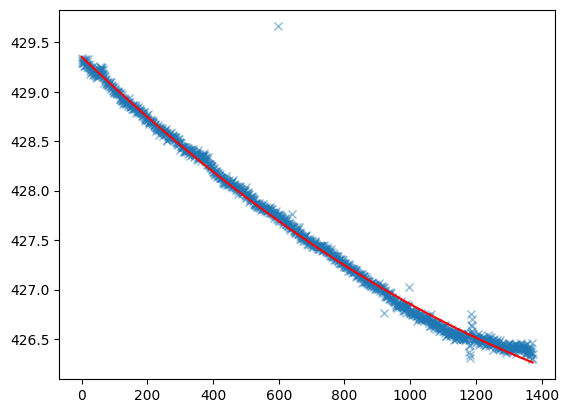

In [15]:
plt.plot(xvals, weighted_yaxis_values, 'x', alpha=0.5)
plt.plot(xvals, fitted_polymodel_2(xvals), color='r')

Text(0, 0.5, 'Residual (data-model)')

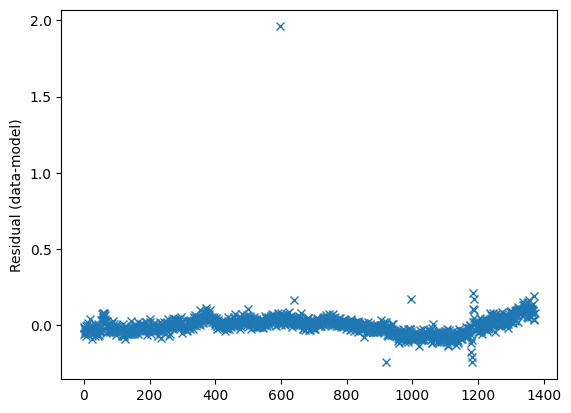

In [16]:
plt.plot(xvals, weighted_yaxis_values-fitted_polymodel_2(xvals), 'x')
plt.ylabel("Residual (data-model)")

Most of the residuals are close to zero which is good but they are not flat telling us that we can do better with the fit. Let's try fitting a higher order polynomial. 

In [17]:
polymodel_3 = Polynomial1D(degree=3)
fitted_polymodel = linfitter(polymodel_3, xvals, weighted_yaxis_values)
fitted_polymodel

<Polynomial1D(3, c0=429.26866069, c1=-0.00244095, c2=-0.00000065, c3=0.)>

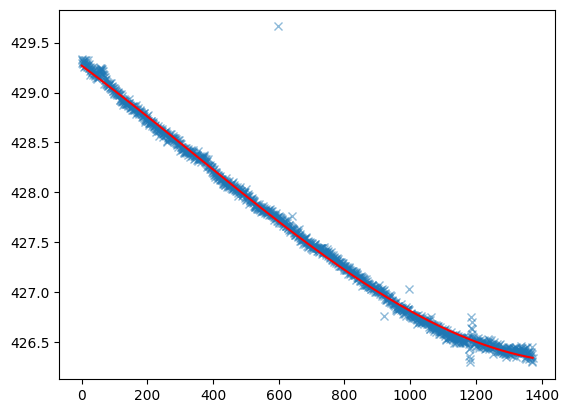

In [18]:
plt.plot(xvals, weighted_yaxis_values, 'x', alpha=0.5)
plt.plot(xvals, fitted_polymodel(xvals), color='r')

Text(0, 0.5, 'Residual (data-model)')

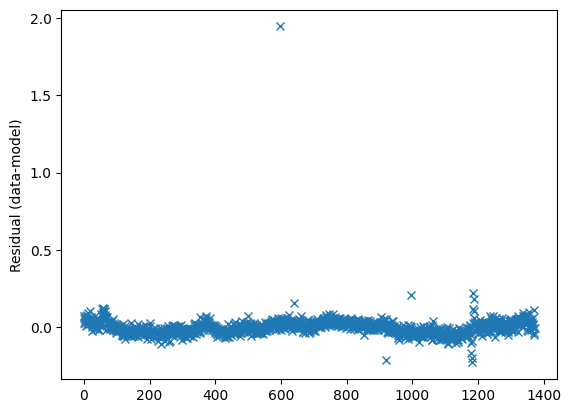

In [19]:
plt.plot(xvals, weighted_yaxis_values-fitted_polymodel(xvals), 'x')
plt.ylabel("Residual (data-model)")

And compare the trace to the data:

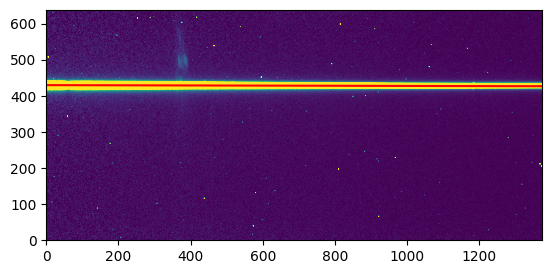

In [20]:
plt.imshow(betacmi2d, origin='lower', vmin=0, vmax=1000)
plt.plot(xvals, fitted_polymodel(xvals), color='red')

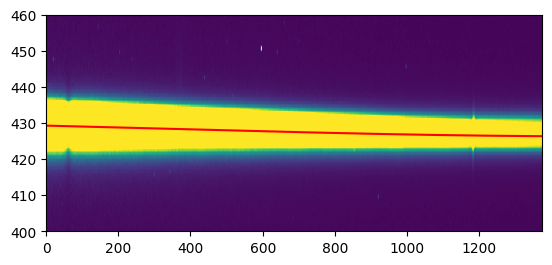

In [21]:
plt.imshow(betacmi2d[ylow:yhigh,:], extent=[0,betacmi2d.shape[1],ylow,yhigh], origin='lower', vmax=10000)
plt.gca().set_aspect(10)
plt.plot(xvals, fitted_polymodel(xvals), color='red')

We can zoom in on diffent portions to inspect the fit in more detail: 

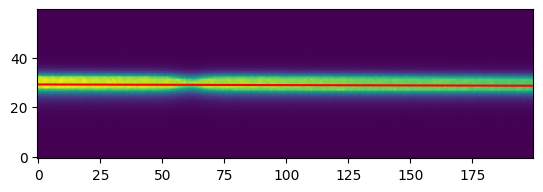

In [22]:
plt.imshow(betacmi2d[ylow:yhigh,:200], origin='lower')
plt.plot(xvals[:200], fitted_polymodel(xvals)[:200]-ylow, color='red')

## Extract data along the trace

First, we should take a "profile" of the trace to see how many pixels on either side of the line we should include.

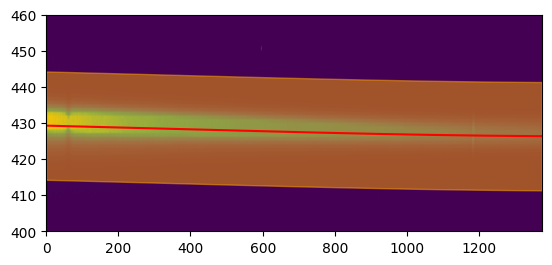

In [23]:
plt.imshow(betacmi2d[ylow:yhigh,:], extent=[0,betacmi2d.shape[1],ylow,yhigh], origin='lower')
plt.gca().set_aspect(10)
pix_range = 15
plt.fill_between(xvals, fitted_polymodel(xvals)-pix_range,
                fitted_polymodel(xvals)+pix_range,
                color='orange', alpha=0.5)
plt.axis((0,betacmi2d.shape[1],ylow,yhigh));

plt.plot(xvals, fitted_polymodel(xvals), color='red')

We'll start with +/- 15 pixels. This is easy to change by specifying the value of "pix_range". 

In [24]:
# start by taking +/- 15 pixels
npixels_to_cut = pix_range
trace_center = fitted_polymodel(xvals)

from scipy.interpolate import CubicSpline

cutouts = np.zeros((2*npixels_to_cut,len(xvals)))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    cutouts[:,ii] = cs(fltys)
cutouts.shape

(30, 1374)

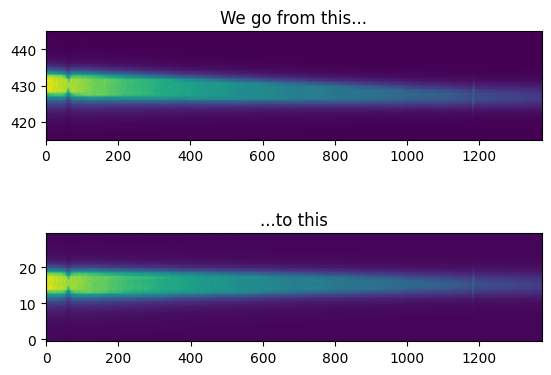

In [25]:
ax1 = plt.subplot(2,1,1)
ax1.imshow(betacmi2d[ylow+15:yhigh-15,:], extent=[0,betacmi2d.shape[1],ylow+15,yhigh-15], origin='lower')
ax1.set_aspect(10)
ax1.set_title("We go from this...")
ax2 = plt.subplot(2,1,2)
ax2.imshow(cutouts, origin='lower')
ax2.set_title("...to this")
ax2.set_aspect(10)

Next, we want to get a sense of the shape of the signal along the trace. To do that, we look at the trace profile. 

Text(0, 0.5, 'Average source profile')

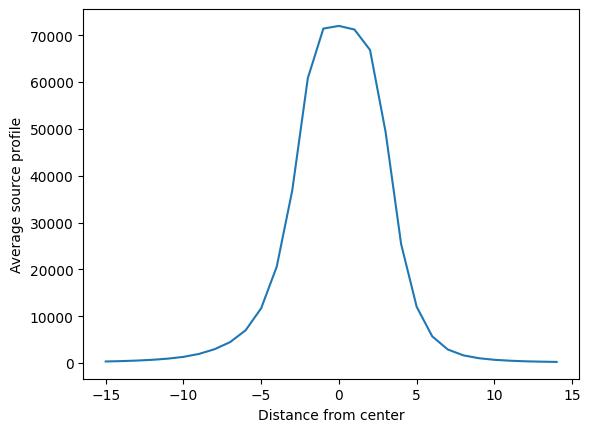

In [26]:
mean_trace_profile = (cutouts.T - background).mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
plt.plot(trace_profile_xaxis, mean_trace_profile)
plt.xlabel("Distance from center")
plt.ylabel("Average source profile")

We will fit that profile with a Gaussian using the Gaussian model profile and non-linear fitter from astropy. 

In [27]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile


<Gaussian1D(amplitude=77526.20397437, mean=0.18727919, stddev=2.68908461)>

Text(0, 0.5, 'Average source profile')

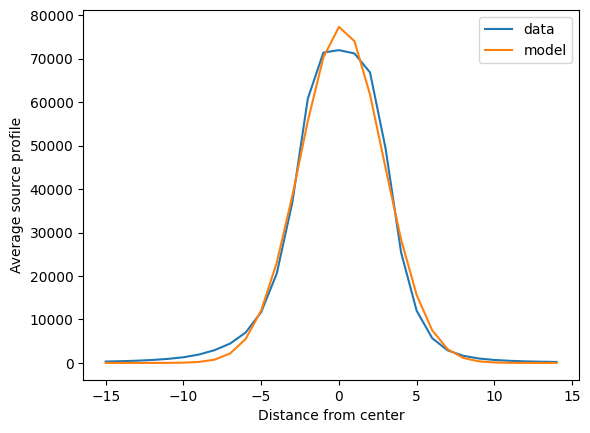

In [28]:
plt.plot(trace_profile_xaxis, mean_trace_profile, label='data')
plt.plot(trace_profile_xaxis, model_trace_profile, label='model')
plt.legend(loc='best')
plt.xlabel("Distance from center")
plt.ylabel("Average source profile")

## Extract the spectrum along the trace. 

We can get the 1D spectrum by taking a straightforward average of the pixels along the trace. 

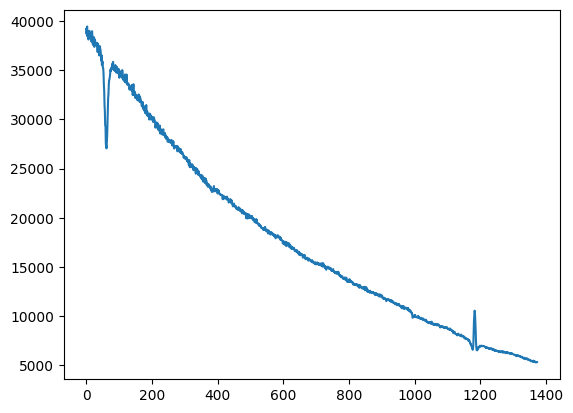

In [29]:
average_spectrum = (cutouts.T - background).mean(axis=1)
plt.plot(average_spectrum)

This looks pretty good! But we can do even better using the trace-weighted average. We can use with the average trace profile  or the Gaussian model fit to it in the steps above. Let's try both. 

In [30]:
# trace-weighted average 
trace_avg_spectrum = np.zeros(len(xvals))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=mean_trace_profile, axis=0)])
trace_avg_spectrum.shape

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_12102/1765832647.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=mean_trace_profile, axis=0)])


(1374,)

In [31]:
# gaussian weights 
gaussian_trace_avg_spectrum = np.zeros(len(xvals))

for yval, ii in zip(trace_center, xvals):
    intys = np.arange(2*npixels_to_cut)+(int(yval)-npixels_to_cut)
    fltys = np.arange(2*npixels_to_cut)+(yval-npixels_to_cut)

    cs = CubicSpline(intys, betacmi2d[intys, ii])
    gaussian_trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=model_trace_profile, axis=0)])
gaussian_trace_avg_spectrum.shape

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_12102/4045008947.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gaussian_trace_avg_spectrum[ii] = np.array([np.average(cs(fltys) - background, weights=model_trace_profile, axis=0)])


(1374,)

Let's see how they compare. 

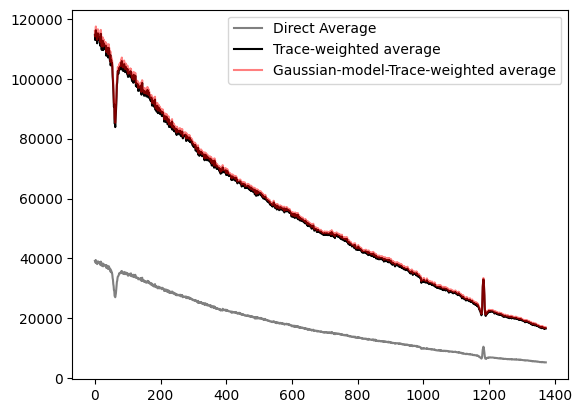

In [32]:
plt.plot(average_spectrum, label="Direct Average", color='gray')
plt.plot(trace_avg_spectrum, label='Trace-weighted average', color='black')
plt.plot(gaussian_trace_avg_spectrum, label='Gaussian-model-Trace-weighted average', alpha=0.5, color='red')
plt.legend(loc='best')

Notice (1) that we extract a lot more counts with the weighted extraction and (2) that the trace-weighted and Gaussian-weighted extractions give very similar results. 

## Apply the wavelength solution. 

Now we extract the appropriate wavelength solution from the wavelength cube. 

In [33]:
wav_sol

array([[4788.03885523, 4789.53175913, 4791.02466304, ..., 6834.81010582,
        6836.30300973, 6837.79591363],
       [4787.34546019, 4788.83823715, 4790.33101412, ..., 6833.9426836 ,
        6835.43546057, 6836.92823753],
       [4786.43067406, 4787.92463263, 4789.4185912 , ..., 6834.64787944,
        6836.14183801, 6837.63579659],
       ...,
       [4772.47172606, 4773.98846958, 4775.50521311, ..., 6851.92709834,
        6853.44384186, 6854.96058539],
       [4774.49093303, 4776.00543109, 4777.51992914, ..., 6850.86776083,
        6852.38225888, 6853.89675693],
       [4775.96958138, 4777.48230327, 4778.99502515, ..., 6849.9112871 ,
        6851.42400899, 6852.93673087]], dtype='>f8')

In [34]:
# gaussian weights 
wave_trace_spectrum = np.array([np.average(
    wav_sol[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
    weights=model_trace_profile)
                               for yval, ii in zip(trace_center, xvals)])


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_12102/1956050333.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$ [$\AA$]')


Text(0, 0.5, 'counts')

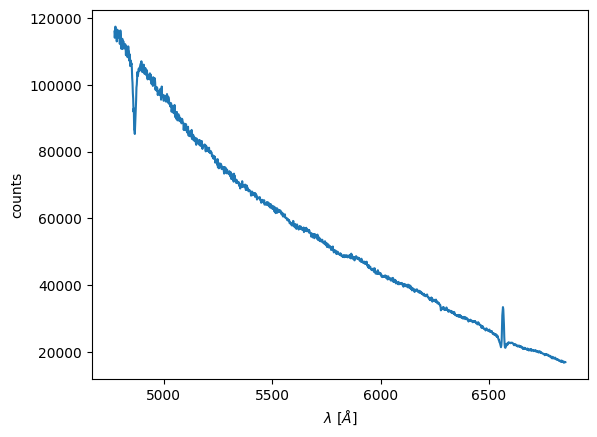

In [35]:
plt.plot(wave_trace_spectrum, gaussian_trace_avg_spectrum)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('counts')

Finally, save the 1D spectrum and the wavelength solution. 

In [37]:
np.save('/reduced/betacmi_spec.npy', gaussian_trace_avg_spectrum)
np.save('/reduced/betacmi_wave.npy', wave_trace_spectrum)

Notice that castor is a double star with both components in the slit. You'll have to play around with the extraction area to extract both components separately. 

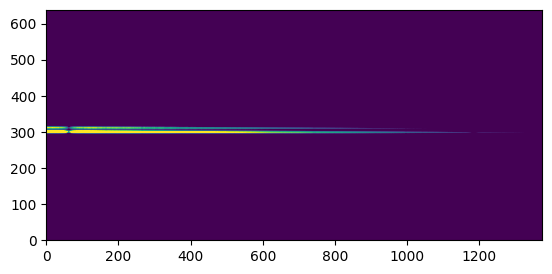

In [38]:
plt.imshow(castor2d, origin='lower', vmin=5000, vmax=20000)